# Prediction of Stock Direction 
This notebook aims to predict market prices with machine learning.

Data from ```'HKEX', 'NYSE', 'NASDAQ', 'AMEX'``` during ```1998-01-01 to 2021-09-07``` was employed.

In [42]:
# Environment variables
from dotenv import load_dotenv
load_dotenv("mysql.env")

import os
import sys
import mysql.connector

import pandas as pd
import numpy as np
import time
import math

import matplotlib.pyplot as plt

import sklearn.preprocessing as prep
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

print('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
print(sys.version)

Machine: Darwin x86_64

3.8.12 | packaged by conda-forge | (default, Sep 16 2021, 01:59:00) 
[Clang 11.1.0 ]


# List of Stocks and ETFs
Provided by Thomas Choi.

In [2]:
stock_list = pd.read_csv("stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("stocks_and_etfs/etf_list.csv")

In [3]:
stock_symbol = stock_list.iloc[0,0]
stock_symbol

'MSFT'

## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [4]:
HOST=os.environ.get("HOST")
PORT=os.environ.get("PORT")
USER=os.environ.get("USER")
PASSWORD=os.environ.get("PASSWORD")

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

# Load Data

In [50]:
df = histdailyprice3.copy()
df.set_index("Date", drop=True, inplace=True)

# Stock Dataset

In [51]:
df.head()

,Close,Open,High,Low,Volume
Date,,,,,
1998-01-01,16.157,16.157,16.157,16.157,0
1998-01-02,16.204,16.438,16.188,16.392,4973300
1998-01-05,16.407,16.704,15.984,16.298,10051300
1998-01-06,16.219,16.625,16.157,16.392,8484500
1998-01-07,16.235,16.399,15.938,16.195,7690300


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6147 entries, 1998-01-01 to 2021-09-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6147 non-null   float64
 1   Open    6147 non-null   float64
 2   High    6147 non-null   float64
 3   Low     6147 non-null   float64
 4   Volume  6147 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 288.1+ KB


In [53]:
# Percentage of nullity by column
missing_perc = df.isnull().mean() * 100
print('Percentage of Missing Values:\n', missing_perc)

Percentage of Missing Values:
 Close     0.0
Open      0.0
High      0.0
Low       0.0
Volume    0.0
dtype: float64


In [54]:
# Descriptive statistics
df.describe()

,Close,Open,High,Low,Volume
count,6147.000000,6147.000000,6147.000000,6147.000000,6.147000e+03
mean,53.160964,53.700698,52.619410,53.179159,4.411060e+07
std,51.896527,52.360775,51.438644,51.941706,2.894696e+07
min,15.200000,15.620000,14.870000,15.150000,0.000000e+00
25%,26.690000,26.950000,26.400000,26.665000,2.517020e+07
50%,30.640000,30.945000,30.345000,30.660000,3.865060e+07
75%,49.905000,50.570000,49.525000,49.955000,5.709925e+07
max,305.020000,305.840000,302.004000,304.650000,5.910786e+08


# Data Preprocessing

In [55]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
df["Close"] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [13]:
# Normalize data
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [14]:
# Split the data to X_train, y_train, X_test, y_test
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

# Build LSTM Network
LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [30]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [31]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (5513, 20, 5)
y_train (5513,)
X_test (613, 20, 5)
y_test (613,)


In [32]:
model = build_model([X_train.shape[2], window, 100, 1])

Compilation Time :  0.011245012283325195


# Train the network

In [33]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=5,
    validation_split=0.1,
    verbose=0)

2021-10-29 14:03:59.006072: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [35]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.62 MSE (0.79 RMSE)
Test Score: 0.32 MSE (0.57 RMSE)


# Visualize the Prediction

In [36]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

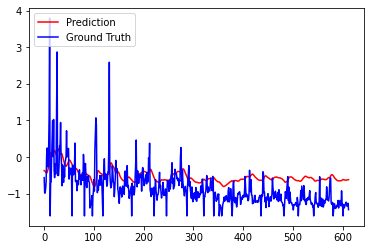

In [40]:
plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()